In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

In [2]:
ifmha = pd.read_csv('./tauraat-230322-150349.csv', converters={'site_no': str}, low_memory=False)

In [3]:
us = gpd.read_file('./data/us_shpfile/s_08mr23.shp')

In [4]:
df = ifmha['site_no'].value_counts().to_frame()

In [5]:
df.head()

,site_no
06807000,6580
06486000,5477
06610000,5455
07022000,3100
06601200,2992


In [7]:
df['latitude'] = ifmha.drop_duplicates(subset='site_no', keep='first').set_index('site_no')['dec_lat_va']
df['longitude'] = ifmha.drop_duplicates(subset='site_no', keep='first').set_index('site_no')['dec_long_va']

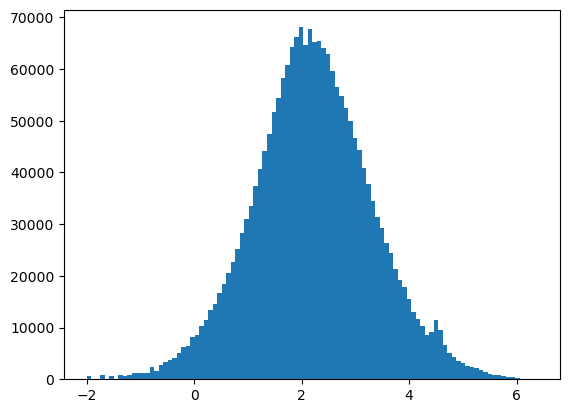

In [6]:
fig, ax = plt.subplots()
ax.hist(np.log10(ifmha['chan_discharge']), bins=100)
plt.show()

In [8]:
df['discharge'] = ifmha.groupby('site_no').apply(lambda x: x['chan_discharge'].median())

In [11]:
df.head()

,site_no,latitude,longitude,discharge
06807000,6580,40.681946,-95.846946,37100.0
06486000,5477,42.485828,-96.413918,31800.0
06610000,5455,41.258887,-95.922514,33200.0
07022000,3100,37.221600,-89.462975,194000.0
06601200,2992,42.007210,-96.241688,31300.0


In [9]:
# Convert ft to meter
df['discharge'] = 0.028316832 * df['discharge']

In [10]:
bins=[0, 10, 50, 100, 500, 1000, 2000, 60000]

for idx, dis in enumerate(bins):
    if idx == len(bins)-1:
        continue
    df.loc[(df['discharge'] >= dis) & (df['discharge'] < bins[idx+1]),'discharge_scale' ] = 10 * (1 + idx**2)

In [14]:
bins=[0, 10, 50, 100, 500, 1000, 2000, 60000]
np.histogram(df['discharge'], bins=bins)

(array([4774, 1091,  262,  283,   36,   18,   34], dtype=int64),
 array([    0,    10,    50,   100,   500,  1000,  2000, 60000]))

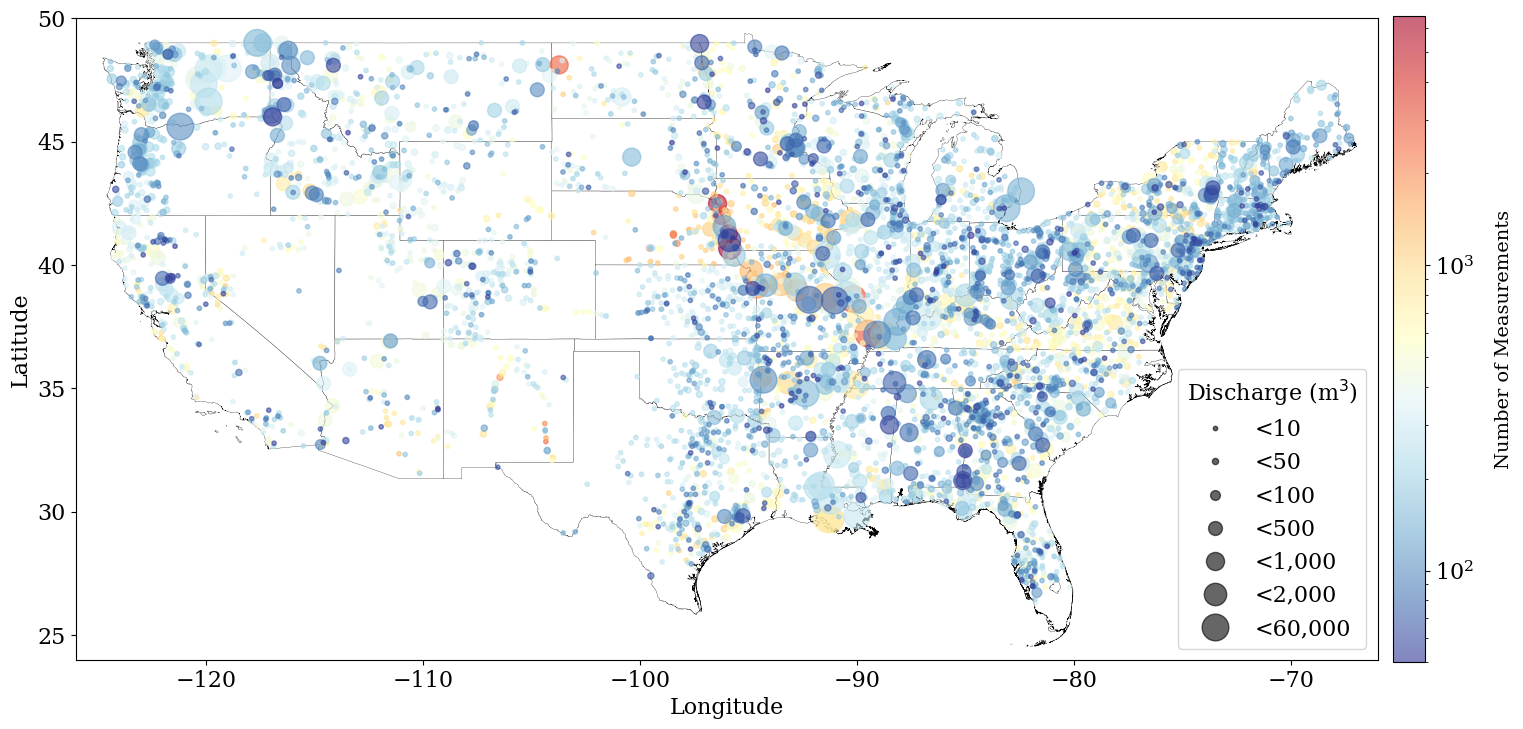

In [38]:
from matplotlib import colors
plt.rcParams.update({
    # 'font.sans-serif': 'Comic Sans MS',
    'font.family': 'serif',
    'font.size': 16
})

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 20))
us.plot(ax=ax, color='#ffffff', edgecolor='#000000', linewidth=0.2)

cmap=plt.cm.get_cmap('RdYlBu').reversed()
sc = ax.scatter(df['longitude'], df['latitude'], s=df['discharge_scale'], c=df['site_no'], alpha=0.6, cmap=cmap, norm=colors.LogNorm())
ax.set_xlim([-126, -66])
ax.set_ylim([24, 50])
ax.set_ylabel('Latitude')
ax.set_xlabel('Longitude')


ax.grid(False)
cbar = plt.colorbar(sc, pad=0.01, shrink=0.42)
cbar.set_label('Number of Measurements', fontsize=14, labelpad=15)

handles, labels = sc.legend_elements(prop="sizes", alpha=0.6)

upper_bounds=['10', '50', '100', '500', '1,000', '2,000', '60,000']
labels = [f'<{x}' for x in upper_bounds]

legend2 = ax.legend(handles, labels, loc="lower right", title=rf"Discharge (m$^{3}$)")

f = 'pdf'
plt.savefig(f'./choropleth.{f}', format=f'{f}', bbox_inches='tight', pad_inches=0.1)
plt.show()

In [40]:
us_albers = us.to_crs(epsg=5071)

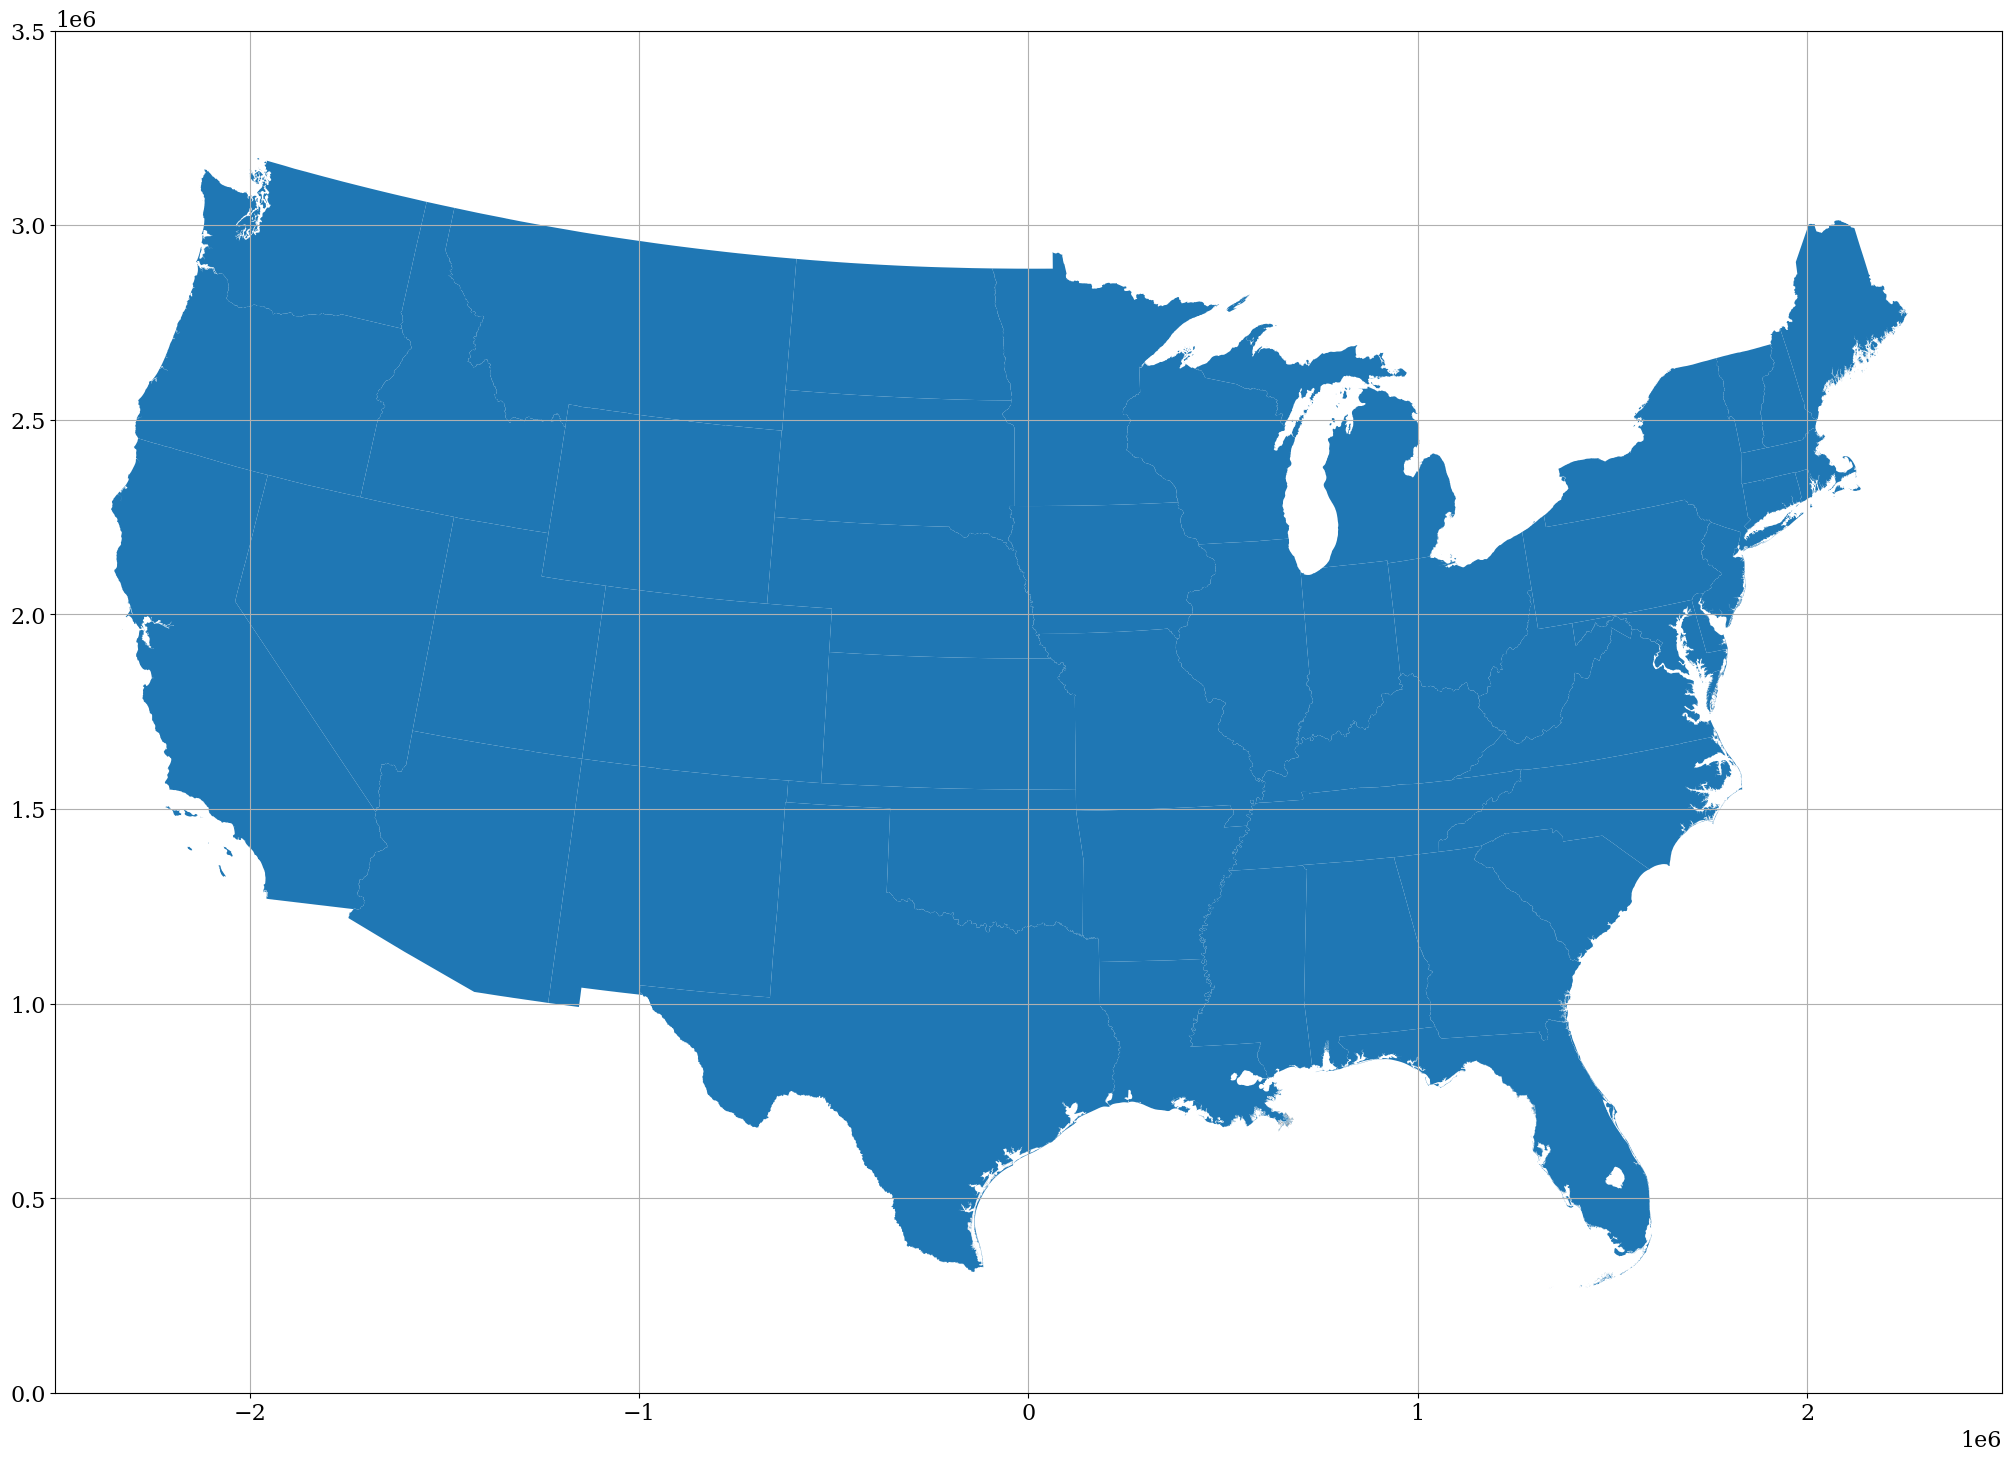

In [41]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20,20), constrained_layout=True)

us_albers.plot(ax=ax, legend=True)
ax.set_xlim([-2.5E6, 2.5E6])
ax.set_ylim([0E6, 3.5E6])


plt.grid(True)
plt.show()